In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
from TSB_AD.snn.spikingjelly.encoders import DynamicReceptiveEncoder

In [2]:
seed = 2002
torch.manual_seed(seed)
np.random.seed(seed)

In [3]:
#file_path = '/home/hwkang/TSB-AD/Datasets/TSB-AD-M/065_SMD_id_9_Facility_tr_737_1st_837.csv'

# recommend to use univariate timeseries data for visualization
src_dir_path = '/home/hwkang/dev-TSB-AD/TSB-AD/Datasets/TSB-AD-U'
target_id = '865' # Modify this!
file_names = os.listdir(src_dir_path)
# search for the file with the target ID
file_path = None
for file_name in file_names:
    if f'{target_id}_' in file_name:
        file_path = os.path.join(src_dir_path, file_name)
        break
print(file_path)

/home/hwkang/dev-TSB-AD/TSB-AD/Datasets/TSB-AD-U/865_OPPORTUNITY_id_24_HumanActivity_tr_2085_1st_2185.csv


In [ ]:
window_size = 400
idx_start = 2000
idx_end = idx_start + window_size

In [5]:
real = True
normalize = 'z-score' # z-score, None

if real: # real data
    df = pd.read_csv(file_path)
    data = df.iloc[idx_start:idx_end, 0]
    label = df.iloc[idx_start:idx_end, 1].values
    if normalize == 'z-score':
        data = (data - data.mean()) / data.std()
    elif normalize == '0-1':
        data = (data - data.min()) / (data.max() - data.min())
    data = data.values.reshape(-1, 1)
    original_data = df.iloc[:, 0].values.reshape(-1, 1)
    original_label = df.iloc[:, 1].values
else: # synthetic data
    pass

In [6]:
print(data.shape, label.shape)

(400, 1) (400,)


In [7]:
tensor = torch.tensor(data, dtype=torch.float32).unsqueeze(0)

In [8]:
print(tensor.shape)

torch.Size([1, 400, 1])


In [9]:
from TSB_AD.snn.params import running_params
running_params['model']['window_size'] = window_size
running_params['ParallelSNNModel']['dropout'] = True
running_params['ParallelSNNModel']['encoding_kernel'] = [11,55,11]
running_params['ParallelSNNModel']['delta_abs'] = False
running_params['ParallelSNNModel']['grad_spike'] = False
for k, v in running_params.items():
    print(f'{k}: {v}')

num_enc_features = 8
encoder = DynamicReceptiveEncoder(
    local_running_params=running_params,
    num_raw_features=1,
    num_enc_features=num_enc_features,
)

data: {'dataset_dir': '/home/hwkang/dev-TSB-AD/TSB-AD/Datasets/TSB-AD-M', 'file_list': '/home/hwkang/dev-TSB-AD/TSB-AD/Datasets/File_List/TSB-AD-M-PW-Eva.csv', 'score_dir': '/home/hwkang/dev-TSB-AD/TSB-AD/scores', 'result_dir': '/home/hwkang/dev-TSB-AD/TSB-AD/results/pw/', 'swap': False, 'shuffle': False}
meta: {'root_dir_path': '/home/hwkang/dev-TSB-AD/TSB-AD/', 'AD_Name': None, 'Encoder_Name': None, 'postfix': None, 'id_code': 0, 'base_file_name': None}
analysis: {'wandb': False, 'spikerate': False, 'spike': False}
model: {'device_type': 'cuda', 'batch_size': 128, 'max_epochs': 1000, 'validation_size': 0.2, 'window_size': 400, 'predict_time_steps': 1}
ParallelSNNModel: {'num_enc_features': 32, 'norm_type': 'ln', 'dropout': True, 'neuron_type': 'spikingjelly', 'step_mode': 'm', 'encoding_kernel': [11, 55, 11], 'tt': False, 'delta_abs': False, 'grad_spike': False, 'parallel': False}


In [10]:
def plot_encoding(data, label, encoding):
    fig, axes = plt.subplots(1 + num_enc_features, 1, figsize=(12, num_enc_features * 2 + 4), sharex=True)
    # axes[0] is always the original data
    axes[0].plot(data, color='blue')
    axes[0].set_title('Original Data')
    axes[0].set_ylabel('Value')
    for t in range(len(label)):
        if label[t] == 1:
            axes[0].axvspan(t - 0.5, t + 0.5, color='red', alpha=0.2)

    for i in range(num_enc_features):
        axes[i + 1].plot(encoding[:, i], color='orange')
        axes[i + 1].set_title(f'Encoding Feature {i + 1}')
        axes[i + 1].set_ylabel('Value')

    plt.xlabel('Time Index')
    # set x-ticks with `idx_start` to `idx_end`
    plt.xticks(ticks=np.arange(0, len(data), 10), labels=np.arange(idx_start, idx_end, 10), rotation=45 if len(data) > 200 else None)
    plt.tight_layout()
    plt.show()

In [11]:
encoding = encoder(tensor)
encoding = encoding.squeeze(0).squeeze(0) # (enc, length) <
encoding = encoding.transpose(1, 0).detach().numpy()  # (length, enc)

After dropout: torch.Size([1, 8, 400])


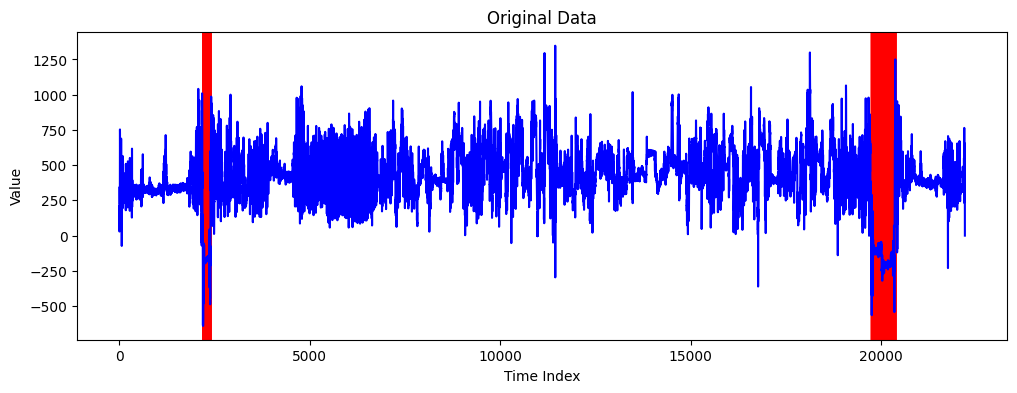

In [12]:
# plot original data and its label
plt.figure(figsize=(12, 4))
plt.plot(original_data, color='blue')
plt.title('Original Data')
plt.ylabel('Value')
for t in range(len(original_label)):
    if original_label[t] == 1:
        plt.axvspan(t - 0.5, t + 0.5, color='red', alpha=0.9)
plt.xlabel('Time Index')
plt.show()

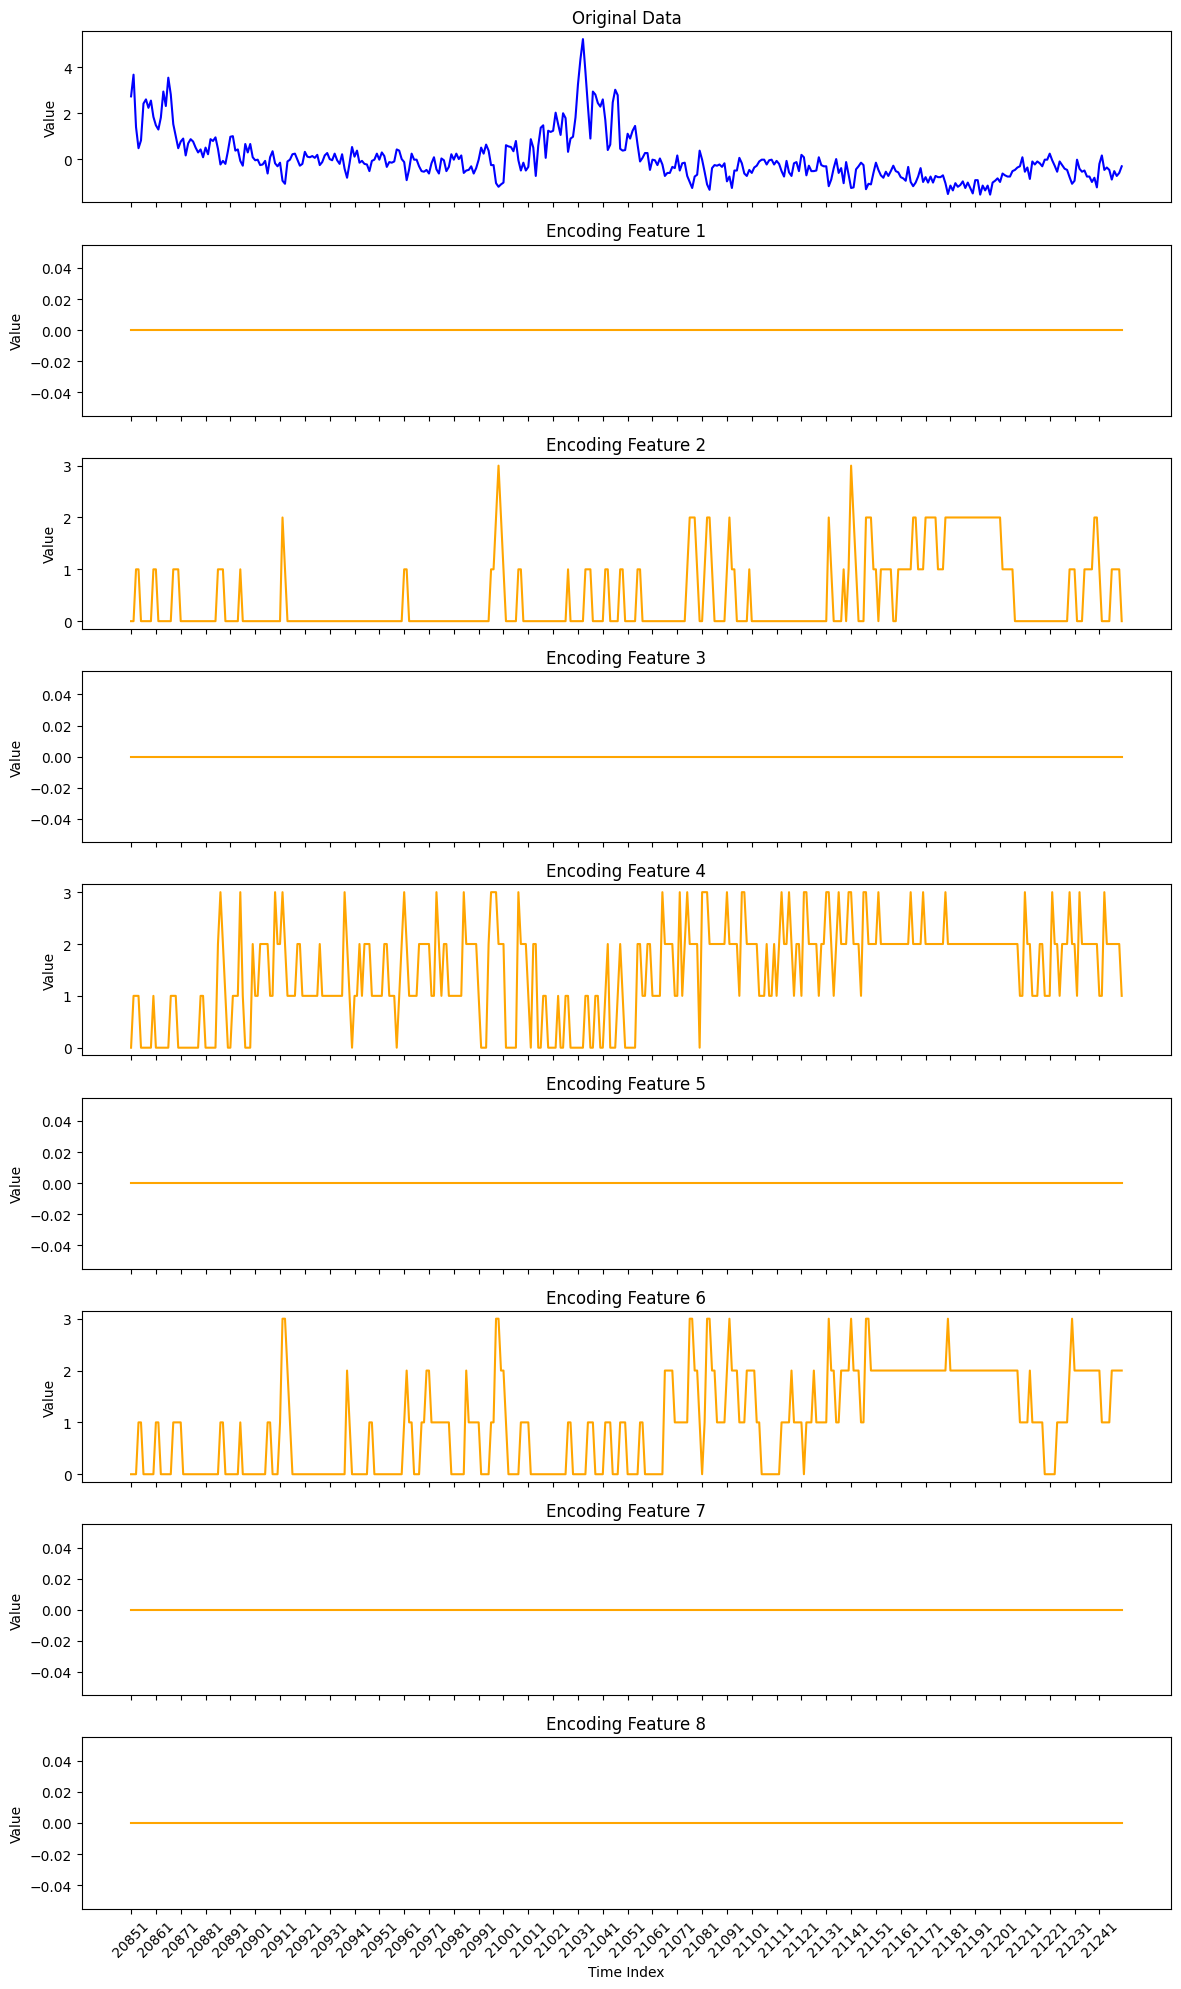

In [13]:
plot_encoding(data, label, encoding)